# 14-01 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)

시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq): 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력  
ex 1. 챗봇(Chatbot): 질문 -> 대답   
ex 2. 기계 번역(Machine Translation): 입력 -> 변역

## 시퀀스-투-시퀀스(Sequence-to-Sequence)

seq2seq: 인코더와 + 디코더  
인코더:  입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터(컨텍스트 벡터(context vector))로 만듬  
디코더: 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력  

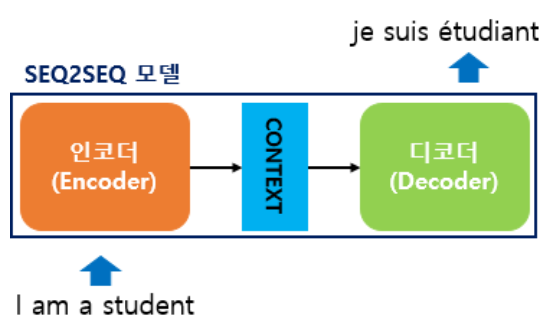  
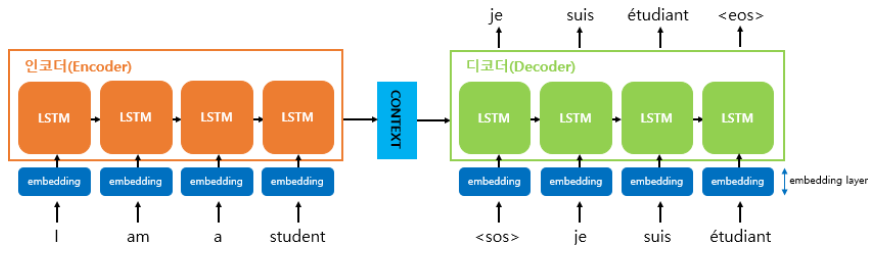  
입력 문장 -(단어 토큰화)-> 단어 토큰 -(워드 임베딩)-> 임베딩 벡터 -(RNN셀 입력)-> 컨텍스트 벡터(인코더 RNN셀의 마지막 시점의 은닉 상태값/디코더 RNN셀의 첫번째 은닉 상태값)(입력 문장의 모든 단어 토큰들의 정보를 요약)  
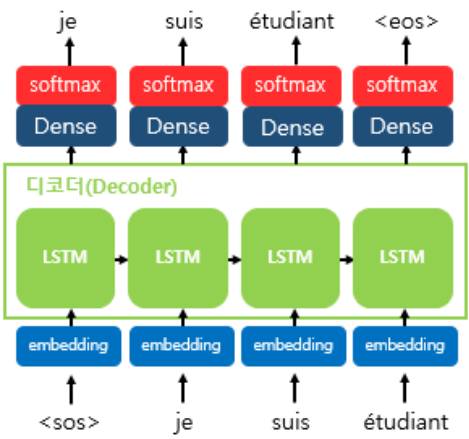

### 훈련 과정

교사 강요(teacher forcing): 디코더에게 인코더가 보낸 컨텍스트 벡터와 실제 정답인 상황인 sos je suis étudiant를 입력 받았을 때, je suis étudiant eos가 나와야 된다고 정답을 알려주면서 훈련

### 테스트 과정

디코더는 오직 컨텍스트 벡터와 sos(문장의 시작을 의미하는 심볼)만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 eos(문장의 끝을 의미하는 심볼)이 다음 단어로 예측될 때까지 반복

## 문자 레벨 기계 번역기(Character-Level Neural Machine Translation) 구현하기

### 병렬 코퍼스 데이터에 대한 이해와 전처리

태깅 작업의 병렬 데이터: 길이가 같은 쌍이 되는 모든 데이터  
seq2seq의 병렬 데이터: 길이가 꼭 같지 않아도 되는 쌍이 되는 모든 데이터  


In [16]:
import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 217975


In [17]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10) # 랜덤으로 선택된 10개의 샘플

,src,tar
7167,Eat your peas.,Mangez vos petits pois.
11935,It's up to you.,Ça dépend de vous.
50603,Tom perused the menu.,Tom consulta le menu.
25214,He is intelligent.,Il est intelligent.
19709,I am out of work.,Je suis au chômage.
18281,You startled us.,Vous nous avez fait peur.
53548,He can't come with us.,Il ne peut venir avec nous.
29898,Where will you go?,Où irez-vous ?
49822,There's nothing left.,Il ne reste rien.
46083,How did you get here?,Comment es-tu arrivé ici ?


번역 문장에 해당되는 프랑스어 데이터는 앞서 배웠듯이 시작을 의미하는 심볼 sos과 종료를 의미하는 심볼 eos을 넣어주어야 합니다. 여기서는 sos와 eos 대신 \t를 시작 심볼, \n을 종료 심볼로 간주하여 추가합니다.

In [18]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
59441,Where did you find it?,\t Où l’as-tu trouvé ? \n
25919,I have no friends.,\t Je n'ai aucune amie. \n
26764,I'm concentrating.,\t Je suis en cours de concentration. \n
3850,Press Enter.,\t Appuyez sur Entrée. \n
43213,We got your message.,\t On a eu ton message. \n
16854,The sea is calm.,\t La mer est calme. \n
30595,You're very brave.,\t Vous êtes fort courageuses. \n
44785,Bring me my slippers.,\t Apporte-moi mes pantoufles ! \n
19921,I face a dilemma.,\t Je fais face à un dilemme. \n
34777,That's all you get.,\t C'est tout ce que tu obtiens. \n


In [19]:
# 문자 집합 구축(토큰 단위가 문자이므로)
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [20]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 80
target 문장의 char 집합 : 103


In [21]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']


In [22]:
# 문자 집합에 인덱스 부여
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, '°': 76, 'é': 77, '’': 78, '€': 79}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 3

In [23]:
# 문자 집합으로부터 훈련 데이터에 정수 인코딩을 수행
encoder_input = []
# 1개의 문장
for line in lines.src:
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])
  encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

decoder_input = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep < len(line)-1:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :',decoder_input[:5]) # sos에서 eos 앞까지

decoder_target = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5]) # sos 뒤에서 eos까지

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]
target 문장의 정수 인코딩 : [[1, 3, 48, 52, 3, 4, 3], [1, 3, 39, 52, 69, 54, 59, 56, 14, 3], [1, 3, 31, 65, 3, 69, 66, 72, 71, 56, 3, 4, 3], [1, 3, 28, 66, 72, 58, 56, 3, 4, 3], [1, 3, 45, 52, 63, 72, 71, 3, 4, 3]]


In [26]:
# 영어 샘플들끼리, 프랑스어 샘플들끼리 길이 맞춰서 패딩
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

source 문장의 최대 길이 : 22
target 문장의 최대 길이 : 76


In [27]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### seq2seq 기계 번역기 훈련시키기

In [28]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

encoder_inputs = Input(shape=(None, src_vocab_size))
# 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정
encoder_lstm = LSTM(units=256, return_state=True) 

# encoder_outputs은 여기서는 불필요
_, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태. 따라서 두 가지를 모두 전달.
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
# 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않음
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")


model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

Epoch 1/40
750/750 [==============================] - 511s 675ms/step - loss: 0.8457 - val_loss: 0.7821
Epoch 2/40
750/750 [==============================] - 414s 553ms/step - loss: 0.5704 - val_loss: 0.6736
Epoch 3/40
750/750 [==============================] - 397s 530ms/step - loss: 0.5004 - val_loss: 0.6009
Epoch 4/40
750/750 [==============================] - 428s 571ms/step - loss: 0.4546 - val_loss: 0.5495
Epoch 5/40
750/750 [==============================] - 512s 682ms/step - loss: 0.4225 - val_loss: 0.5248
Epoch 6/40
750/750 [==============================] - 452s 603ms/step - loss: 0.3975 - val_loss: 0.4948
Epoch 7/40
750/750 [==============================] - 378s 503ms/step - loss: 0.3769 - val_loss: 0.4748
Epoch 8/40
750/750 [==============================] - 432s 576ms/step - loss: 0.3598 - val_loss: 0.4577
Epoch 9/40
750/750 [==============================] - 431s 573ms/step - loss: 0.3462 - val_loss: 0.4398
Epoch 10/40
750/750 [==============================] - 512s 683m

### seq2seq 기계 번역기 동작시키기

seq2seq는 훈련할 때와 동작할 때의 방식이 다릅니다. 전체적인 번역 동작 단계를 정리하면 아래와 같습니다.  
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 SOS에 해당하는 \t를 디코더로 보냅니다.
3. 디코더가 EOS에 해당하는 \n이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 원-핫 벡터 생성
  target_seq = np.zeros((1, 1, tar_vocab_size))
  target_seq[0, 0, tar_to_index['\t']] = 1.

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 문자를 예측 문장에 추가
    decoded_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_tar_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, sampled_token_index] = 1.

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [ ]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index:seq_index+1]
  decoded_sentence = decode_sequence(input_seq)
  print(35 * "-")
  print('입력 문장:', lines.src[seq_index])
  print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력